# RF

In [17]:
import cudf
import cuml
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
from cuml.ensemble import RandomForestClassifier as cuRF
import numpy as np
import time
import joblib

# Convert pandas DataFrame to cuDF
df_gpu = cudf.DataFrame(df)
X = df_gpu.drop('label', axis=1)
y = df_gpu['label']

# Convert data to float32 for better GPU performance
X = X.astype('float32')
y = y.astype('float32')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data using GPU
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}

# Calculate total combinations
total_combinations = len([p for p in ParameterGrid(param_grid)])
print(f"Total parameter combinations: {total_combinations}")

# Initialize variables
best_score = 0
best_params = None
best_model = None

# Function to format time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Grid search with progress tracking
start_time = time.time()
for i, params in enumerate(ParameterGrid(param_grid), 1):
    iteration_start = time.time()
    current_time = time.strftime('%H:%M:%S')

    print(f"\nCombination {i}/{total_combinations} at {current_time}")
    print(f"Parameters: {params}")

    model = cuRF(
        random_state=42,
        **params
    )

    model.fit(X_train_scaled, y_train)
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)

    iteration_time = time.time() - iteration_start

    print(f"Training Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"Iteration Time: {format_time(iteration_time)}")

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
total_time = time.time() - start_time
print("\n" + "="*50)
print("Grid Search Completed!")
print(f"Total Time: {format_time(total_time)}")
print(f"Best Parameters: {best_params}")
print(f"Best Training Score: {best_model.score(X_train_scaled, y_train):.4f}")
print(f"Best Test Score: {best_score:.4f}")

# Save the best model
joblib.dump(best_model, 'RF_GPU.pkl')

# Fine-tuning phase
print("\nStarting fine-tuning phase...")

# Create fine-tuning grid based on best parameters
fine_tune_grid = {
    'n_estimators': [best_params['n_estimators'] - 50, best_params['n_estimators'], best_params['n_estimators'] + 50],
    'max_depth': [best_params['max_depth'] - 2, best_params['max_depth'], best_params['max_depth'] + 2],
    'max_features': [best_params['max_features']],
    'min_samples_split': [best_params['min_samples_split']]
}

# Fine-tuning search
fine_tune_start = time.time()
for i, params in enumerate(ParameterGrid(fine_tune_grid), 1):
    iteration_start = time.time()
    print(f"\nFine-tuning combination {i}/{len(list(ParameterGrid(fine_tune_grid)))}")

    model = cuRF(
        random_state=42,
        **params
    )

    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
print("\n" + "="*50)
print("Fine-tuning Completed!")
print(f"Final Best Parameters: {best_params}")
print(f"Final Best Score: {best_score:.4f}")

# Save the final model
joblib.dump(best_model, 'RF_GPU_final.pkl')

# For predictions
y_pred = best_model.predict(X_test_scaled)

Total parameter combinations: 54

Combination 1/54 at 05:47:54
Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


Training Score: 0.9324
Test Score: 0.9169
Iteration Time: 00:00:03
New best score: 0.9169

Combination 2/54 at 05:47:58
Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Training Score: 0.9331
Test Score: 0.9178
Iteration Time: 00:00:01
New best score: 0.9178

Combination 3/54 at 05:47:59
Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
Training Score: 0.9332
Test Score: 0.9180
Iteration Time: 00:00:01
New best score: 0.9180

Combination 4/54 at 05:48:01
Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
Training Score: 0.9322
Test Score: 0.9170
Iteration Time: 00:00:00

Combination 5/54 at 05:48:02
Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Training Score: 0.9329
Test Score: 0.9183
Iteration Time: 00:00:01
New best score: 0.9183

Combination 6/54 at 05:48:03
Parameters: {'max_depth': 1

In [18]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test_cpu, y_pred_cpu))
print(confusion_matrix(y_test_cpu, y_pred_cpu))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     16179
         1.0       0.98      0.98      0.98     15932

    accuracy                           0.98     32111
   macro avg       0.98      0.98      0.98     32111
weighted avg       0.98      0.98      0.98     32111

[[15835   344]
 [  381 15551]]


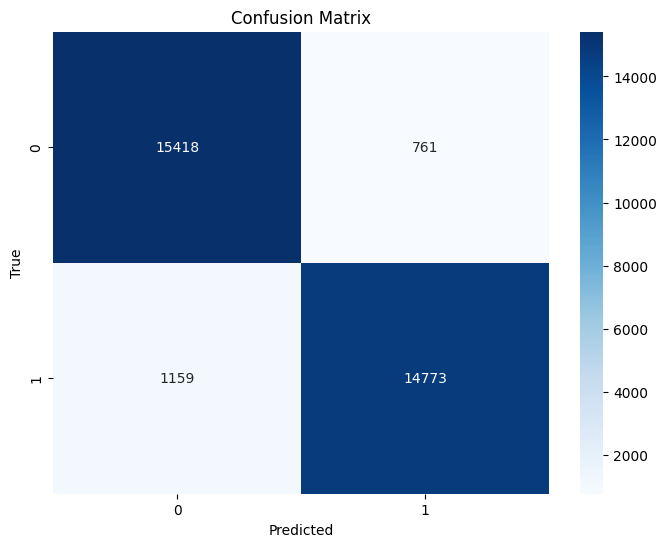

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert predictions and test labels to CPU for plotting
y_test_cpu = y_test.values.get()
y_pred_cpu = y_pred.values.get()

# Create and plot confusion matrix
cm = confusion_matrix(y_test_cpu, y_pred_cpu)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()